### Reply to Review

- We get a review as an input
- find sentiment of the review
- if the sentiment is positive, reply with a thank you note
- if the review is negative
    - run diagnostics on the review, to find issue type, tone, urgency
    - based on the above these three items, we form a reply to the user

In [1]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, Literal
from dotenv import load_dotenv
from pydantic import BaseModel, Field

In [2]:
load_dotenv()

True

In [3]:
model = ChatOpenAI(model='gpt-4o-mini')

In [4]:
class SentimentSchema(BaseModel):
    sentiment: Literal["positive", "negative"] = Field(description="The sentiment of the review")

structured_model = model.with_structured_output(SentimentSchema)

In [5]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal['UX', 'Performance', 'Bug', 'Support', 'Other'] = Field(description="The type of issue in the review")
    tone: Literal['Angry', 'Frustrated', 'Disappointed', 'Calm'] = Field(description="The tone of the review")
    urgency: Literal['Low', 'Medium', 'High'] = Field(description="The urgency of the review")

structured_model_2 = model.with_structured_output(DiagnosisSchema)

In [6]:
prompt = f"What is the sentiment of the following review: too bad!!"
structured_model.invoke(prompt)

SentimentSchema(sentiment='negative')

Now we can start with graph and its components

In [7]:
# define graph state
class ReviewState(TypedDict):
    review: str
    sentiment: Literal['positive', 'negative']
    diagnosis: dict
    response: str

In [12]:
def find_sentiment(state: ReviewState):
    prompt = f"What is the sentiment of the following review \n\n Review: {state['review']}"
    sentiment = structured_model.invoke(prompt).sentiment
    return {'sentiment': sentiment}

def check_sentiment(state: ReviewState) -> Literal['positive_response', 'run_diagnostics']:

    if state['sentiment'] == 'positive':
        return 'positive_response'
    else:
        return 'run_diagnostics'

def positive_response(state: ReviewState):
    prompt = f"Write a warning response to the following review \n\n Review: {state['review'] }\n\n Also, ask user to leave feedback on our website"

    response = model.invoke(prompt).content

    return {'response': response}

def run_diagnostics(state: ReviewState):

    prompt = f"Run diagnostics on the following negative review \n\n Review: {state['review']} \n\n extract issue type, tone, urgency from the review"

    diagnosis = structured_model_2.invoke(prompt)

    return {'diagnosis': diagnosis.model_dump()}

def negative_response(state: ReviewState):
    prompt = f"""
    You are a customer support assistant.

    The user has provided the following feedback:
    issue type: {state['diagnosis']['issue_type']}
    tone: {state['diagnosis']['tone']}
    urgency: {state['diagnosis']['urgency']}

    Write a empathetic response to the user based on the above feedback.
    """

    response = model.invoke(prompt).content

    return {'response': response}


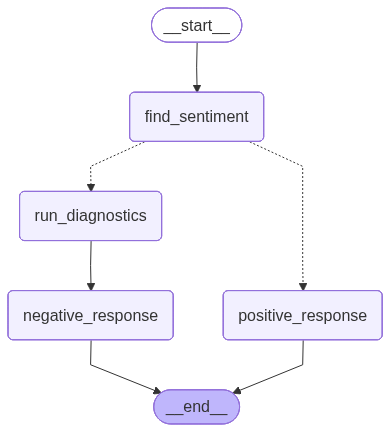

In [13]:
# define graph
graph = StateGraph(ReviewState)

# add nodes to the graph
graph.add_node('find_sentiment', find_sentiment)
graph.add_node('positive_response', positive_response)
graph.add_node('run_diagnostics', run_diagnostics)
graph.add_node('negative_response', negative_response)


# add edges to the graph
graph.add_edge(START, 'find_sentiment')
graph.add_conditional_edges('find_sentiment', check_sentiment)

graph.add_edge('positive_response', END)
graph.add_edge('run_diagnostics', 'negative_response')
graph.add_edge('negative_response', END)

# compile the graph
workflow = graph.compile()
workflow

In [14]:
initial_state = {'review': 'The product is too expensive, and not at all intuitive to use, I am very disappointed with this product, I feel the UI is not user friendly at all.',}
workflow.invoke(initial_state)

{'review': 'The product is too expensive, and not at all intuitive to use, I am very disappointed with this product, I feel the UI is not user friendly at all.',
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'UX',
  'tone': 'Disappointed',
  'urgency': 'Medium'},
 'response': "Dear [User's Name],\n\nThank you for taking the time to share your feedback with us. I’m truly sorry to hear that your experience didn’t meet your expectations. Your disappointment is understandable, and we appreciate you bringing this to our attention.\n\nWe strive to create a seamless and enjoyable user experience, and it’s clear we fell short in this instance. I’d love to learn more about the specific issues you encountered so we can address them and improve our services. Your insights are invaluable to us.\n\nPlease feel free to reach out with any additional details or suggestions you might have. We’re here to help and want to ensure that your future experiences with us are positive.\n\nThank you for

In [15]:
initial_state = {'review': 'The product is very intuitive to use, I am very happy with this product, I can safely say this is the best product I have ever used. I will refer this to my friends.'}
workflow.invoke(initial_state)

{'review': 'The product is very intuitive to use, I am very happy with this product, I can safely say this is the best product I have ever used. I will refer this to my friends.',
 'sentiment': 'positive',
 'response': 'Subject: Thank You for Your Review!\n\nDear [Reviewer’s Name],\n\nThank you so much for taking the time to share your positive experience with our product! We are thrilled to hear that you find it intuitive and that it has become your favorite. Your recommendation to friends means the world to us!\n\nIf you have any further feedback or suggestions, we would love to hear them. Please consider sharing your thoughts on our website as well; it helps us improve and serve our customers even better.\n\nThanks again for your support!\n\nBest regards,  \n[Your Name]  \n[Your Position]  \n[Your Company]  '}